## Packets

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sn
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn.conv import SAGEConv
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(torch_geometric.__version__)
print(device)

1.11.0
2.0.4
cuda


## GNNs

In [28]:
class GNN2L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16, aggr='max')
        self.conv2 = SAGEConv(16, int(data.num_classes), aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

class GNN4L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16, aggr='max')
        self.conv2 = SAGEConv(16, 16, aggr='max')
        self.conv3 = SAGEConv(16, 16, aggr='max')
        self.conv4 = SAGEConv(16, int(data.num_classes), aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)

        return F.log_softmax(x, dim=1)

class GNN7L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 16)
        self.conv4 = SAGEConv(16, 16)
        self.conv5 = SAGEConv(16, 16)
        self.conv6 = SAGEConv(16, 16)
        self.conv7 = SAGEConv(16, int(data.num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

## Dataset loader

In [3]:
# Dataset class: it allows to translate a vector (Graph, Attributes, Labels)
# into a dataset compatible with the PyTorch models.
# 
# Parameters:
# - G: NetworkX graph
# - Labels: of the nodes used for classification
# - attributes: List of the nodes' attributes

class MyDataset(InMemoryDataset):
  def __init__(self, G, labels, attributes, num_classes=2):
    super(MyDataset, self).__init__('.', None, None, None)

    # import data from the networkx graph with the attributes of the nodes
    data = from_networkx(G, attributes)
      
    y = torch.from_numpy(labels).type(torch.long)

    data.x = data.x.float()
    data.y = y.clone().detach()
    data.num_classes = num_classes

    # Using train_test_split function from sklearn to stratify train/test/val sets
    indices = range(G.number_of_nodes())
    # Stratified split of train/test/val sets. Returned indices are used to create the masks
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(data.x, data.y, indices, test_size=0.3, stratify=labels, random_state=42)
    # To create validation set, test set is splitted in half
    X_test, X_val, y_test, y_val, test_idx, val_idx = train_test_split(X_test, y_test, test_idx, test_size=0.5, stratify=y_test, random_state=42)

    n_nodes = G.number_of_nodes()
    train_mask  = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask   = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask    = torch.zeros(n_nodes, dtype=torch.bool)
    
    for idx in train_idx:
      train_mask[idx] = True

    for idx in test_idx:
      test_mask[idx] = True
    
    for idx in val_idx:
      val_mask[idx] = True

    data['train_mask']  = train_mask
    data['test_mask']   = test_mask
    data['val_mask']    = val_mask

    self.data, self.slices = self.collate([data])

## Training Function

In [23]:
def train(model, data, epochs = 200, classes = ['0','1'], lr = 0.001, weight_decay=0, cm_title = 'GNN', num_layers = 7):
    title = cm_title + '_' + str(epochs) + '_' + str(weight_decay).replace('.', '_')

    model_path  = 'Models/' + title
    image_path  = 'Images/' + title
    report_path = 'Reports/' + title + '.csv'

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_mask  = data['train_mask']
    test_mask   = data['test_mask']
    val_mask    = data['val_mask']

    labels    = data.y
    output = ''

    # list to plot the train accuracy
    train_acc_curve = []
    train_lss_curve = []

    best_train_acc  = 0
    best_val_acc    = 0
    # best_test_acc   = 0
    best_train_lss  = 999
    best_loss_epoch = 0

    for e in tqdm(range(epochs+1)):
        model.train()
        optimizer.zero_grad()
        logits      = model(data)
        output      = logits.argmax(1)
        # train_loss  = F.cross_entropy(logits[train_mask], labels[train_mask])
        train_loss  = F.nll_loss(logits[train_mask], labels[train_mask])
        train_acc   = (output[train_mask] == labels[train_mask]).float().mean()
        train_loss.backward()
        optimizer.step()

        # Append train acc. to plot curve later
        train_acc_curve.append(train_acc.item())
        train_lss_curve.append(train_loss.item())

        if train_acc > best_train_acc:
            best_train_acc = train_acc

        # Evaluation and test
        model.eval()
        logits      = model(data)
        output      = logits.argmax(1)
        # val_loss    = F.cross_entropy(logits[val_mask], labels[val_mask])
        val_loss    = F.nll_loss(logits[val_mask], labels[val_mask])
        val_acc     = (output[val_mask] == labels[val_mask]).float().mean()
        # test_acc    = (output[test_mask] == labels[test_mask]).float().mean()

        # Update best test/val acc.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # if test_acc > best_test_acc:
        #     best_test_acc = test_acc
        
        # Save model with best train loss
        if train_loss < best_train_lss:
            best_train_lss = train_loss
            best_loss_epoch = e
            torch.save(model.state_dict(), model_path)

        if e % 20 == 0 or e == epochs:
            print('[Epoch: {:04d}]'.format(e),
            'train loss: {:.4f},'.format(train_loss.item()),
            'train acc: {:.4f},'.format(train_acc.item()),
            'val loss: {:.4f},'.format(val_loss.item()),
            'val acc: {:.4f} '.format(val_acc.item()),
            '(best train acc: {:.4f},'.format(best_train_acc.item()),
            'best val acc: {:.4f},'.format(best_val_acc.item()),
            'best train loss: {:.4f} '.format(best_train_lss),
            '@ epoch', best_loss_epoch ,')')
    
    # Plot training accuracy curve
    plt.figure(figsize = (12,7))
    plt.plot(train_acc_curve)
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.show()

    plt.figure(figsize = (12,7))
    plt.plot(train_lss_curve)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.show()

    # Load best model
    loaded_model = None
    if num_layers == 2:
        loaded_model = GNN2L_Sage(data).to(device)
    elif num_layers == 4:
        loaded_model = GNN4L_Sage(data).to(device)
    elif num_layers == 7:
        loaded_model = GNN7L_Sage(data).to(device)
    else:
        print('Wrong number of layer. No model available with', num_layers, 'layers')
        return -1

    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model.eval()
    logits = loaded_model(data)
    output = logits.argmax(1)

    print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

    class_report = classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), output_dict=True)
    classification_report_dataframe = pd.DataFrame(class_report)
    classification_report_dataframe.to_csv(report_path)

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        else:
            sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        plt.title(cm_title)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        if norm == None:
            plt.savefig(image_path + '_notNorm.png')
        else:
            plt.savefig(image_path + '_Norm.png')

    return output

## NeDBIT Multiclass

### Load dataset

(18736, 2)


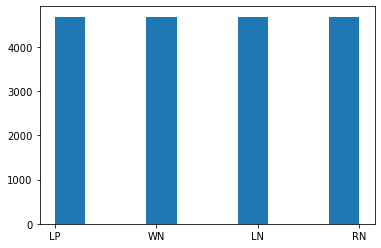

In [5]:
G = nx.read_gml('Graphs/graph_with_normalized_nedbit.gml')

seed_genes          = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_seed_genes.txt', header=None, sep=' ')
seed_genes.columns  = ["name", "GDA Score"]
seeds_list          = seed_genes["name"].values.tolist()

nedbit_scores = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features_Score.csv')

# Remove seed genes
nedbit_scores_not_seed = nedbit_scores[~nedbit_scores['name'].isin(seeds_list)]
print(nedbit_scores_not_seed.shape)

# Sort scores for quartile division
nedbit_scores_not_seed = nedbit_scores_not_seed.sort_values(by = "out", ascending = False)
pseudo_labels = pd.qcut(x = nedbit_scores_not_seed["out"], q = 4, labels = ["RN", "LN", "WN", "LP"])

plt.hist(pseudo_labels)
plt.show()

In [6]:
nedbit_scores_not_seed['label'] = pseudo_labels

nedbit_scores_seed = nedbit_scores[nedbit_scores['name'].isin(seeds_list)]
nedbit_scores_seed = nedbit_scores_seed.assign(label = 'P')

# Convert dataframe to dict for searching nodes and their labels
not_seed_labels = dict(zip(nedbit_scores_not_seed['name'], nedbit_scores_not_seed['label']))
seed_labels     = dict(zip(nedbit_scores_seed['name'], nedbit_scores_seed['label']))

labels_dict = {'P':0, 'LP': 1, 'WN': 2, 'LN': 3, 'RN': 4}
labels = []

for node in G:
    if node in not_seed_labels:
        labels.append(labels_dict[not_seed_labels[node]])
    else:
        labels.append(labels_dict[seed_labels[node]])

labels = np.asarray(labels)
len(labels)

19761

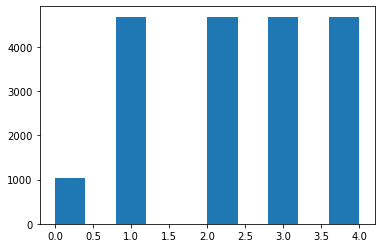

In [7]:
attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

dataset_with_nedbit = MyDataset(G, labels, attributes, num_classes=5)
data_with_nedbit = dataset_with_nedbit[0]

plt.hist(labels)
plt.show()

### 2 Layers

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 1416.6721, train acc: 0.2316, val loss: 1313.3909, val acc: 0.2371  (best train acc: 0.2316, best val acc: 0.2371, best train loss: 999.0000  @ epoch 0 )
[Epoch: 0020] train loss: 935.5636, train acc: 0.2167, val loss: 577.3289, val acc: 0.2371  (best train acc: 0.2323, best val acc: 0.2371, best train loss: 935.5636  @ epoch 20 )
[Epoch: 0040] train loss: 722.0756, train acc: 0.2214, val loss: 302.9381, val acc: 0.2388  (best train acc: 0.2323, best val acc: 0.2391, best train loss: 698.4193  @ epoch 39 )
[Epoch: 0060] train loss: 532.3002, train acc: 0.2590, val loss: 235.6854, val acc: 0.2384  (best train acc: 0.2657, best val acc: 0.2391, best train loss: 528.3857  @ epoch 58 )
[Epoch: 0080] train loss: 404.3631, train acc: 0.2972, val loss: 140.5530, val acc: 0.2465  (best train acc: 0.3055, best val acc: 0.2469, best train loss: 404.3631  @ epoch 80 )
[Epoch: 0100] train loss: 319.5390, train acc: 0.3247, val loss: 93.1488, val acc: 0.3926  (best train a

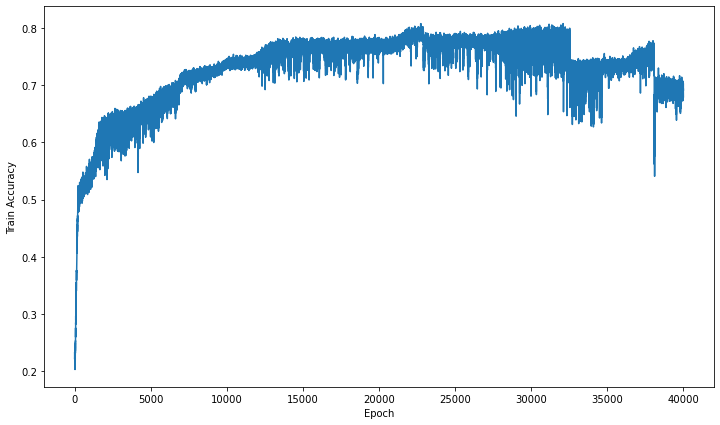

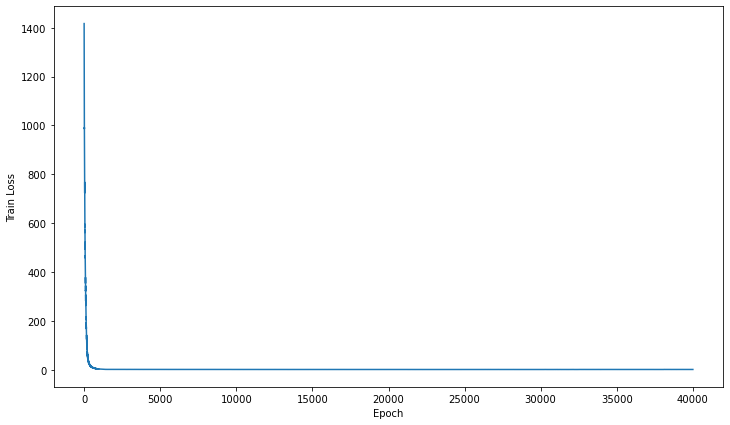

              precision    recall  f1-score   support

           0       1.00      0.84      0.92       154
           1       0.86      1.00      0.93       703
           2       0.90      0.72      0.80       702
           3       0.86      0.91      0.88       703
           4       0.99      1.00      0.99       702

    accuracy                           0.90      2964
   macro avg       0.92      0.89      0.90      2964
weighted avg       0.91      0.90      0.90      2964



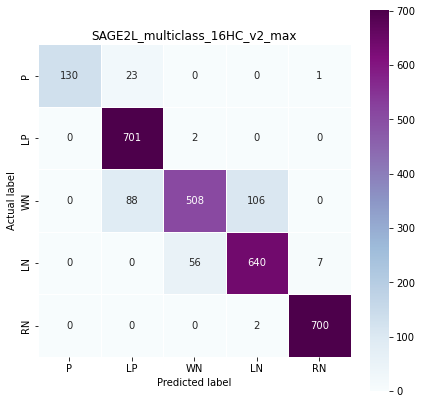

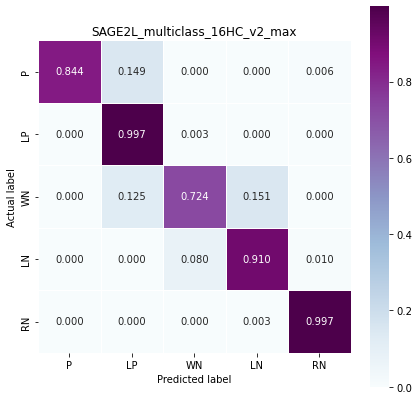

In [26]:
gnn_sage = GNN2L_Sage(data_with_nedbit).to(device)
pred = train(gnn_sage, data_with_nedbit.to(device), 40000, weight_decay=0.0005, cm_title='SAGE2L_multiclass_16HC_v2_max', classes=['P', 'LP', 'WN', 'LN', 'RN'], num_layers=2)

### 4 Layers

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 461.4225, train acc: 0.1210, val loss: 288.6747, val acc: 0.1734  (best train acc: 0.1210, best val acc: 0.1734, best train loss: 461.4225  @ epoch 0 )
[Epoch: 0020] train loss: 46.3379, train acc: 0.1542, val loss: 27.7432, val acc: 0.0664  (best train acc: 0.2320, best val acc: 0.2310, best train loss: 46.3379  @ epoch 20 )
[Epoch: 0040] train loss: 2.7743, train acc: 0.1179, val loss: 2.3376, val acc: 0.1079  (best train acc: 0.2324, best val acc: 0.2482, best train loss: 2.7743  @ epoch 40 )
[Epoch: 0060] train loss: 1.5460, train acc: 0.3465, val loss: 1.5191, val acc: 0.3460  (best train acc: 0.3490, best val acc: 0.3460, best train loss: 1.5460  @ epoch 60 )
[Epoch: 0080] train loss: 1.5001, train acc: 0.3760, val loss: 1.4342, val acc: 0.4776  (best train acc: 0.3865, best val acc: 0.4826, best train loss: 1.4938  @ epoch 79 )
[Epoch: 0100] train loss: 1.4236, train acc: 0.4009, val loss: 1.3129, val acc: 0.4948  (best train acc: 0.4135, best val acc: 

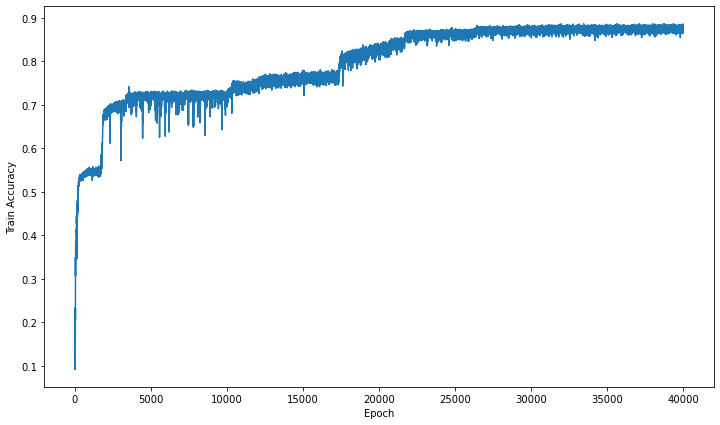

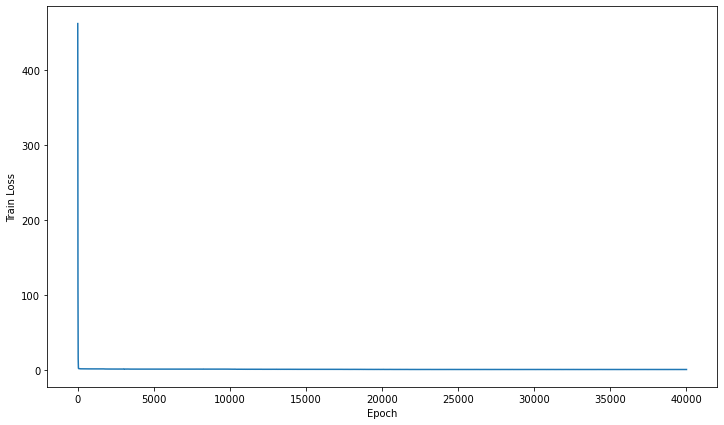

              precision    recall  f1-score   support

           0       0.86      0.36      0.50       154
           1       0.91      0.97      0.94       703
           2       0.90      0.91      0.91       702
           3       0.91      0.95      0.93       703
           4       0.99      0.99      0.99       702

    accuracy                           0.93      2964
   macro avg       0.91      0.84      0.85      2964
weighted avg       0.92      0.93      0.92      2964



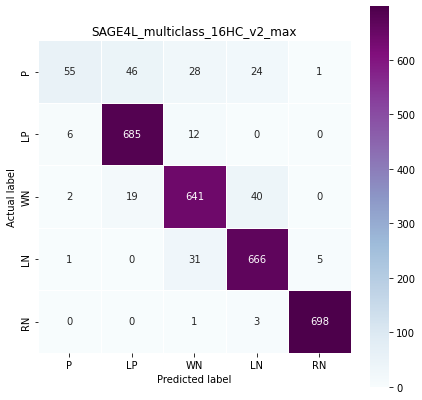

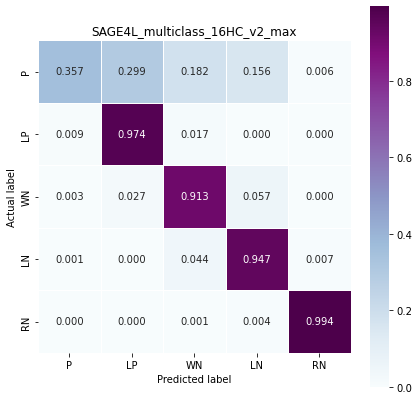

In [27]:
gnn_sage = GNN4L_Sage(data_with_nedbit).to(device)
pred = train(gnn_sage, data_with_nedbit.to(device), 40000, weight_decay=0.0005, cm_title='SAGE4L_multiclass_16HC_v2_max', classes=['P', 'LP', 'WN', 'LN', 'RN'], num_layers=4)

### 7 Layers

  0%|          | 0/40001 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 67.5791, train acc: 0.1681, val loss: 35.4155, val acc: 0.0530  (best train acc: 0.1681, best val acc: 0.0530, best train loss: 67.5791  @ epoch 0 )
[Epoch: 0020] train loss: 5.2124, train acc: 0.2648, val loss: 2.9046, val acc: 0.2405  (best train acc: 0.2805, best val acc: 0.2610, best train loss: 5.2124  @ epoch 20 )
[Epoch: 0040] train loss: 1.8515, train acc: 0.2929, val loss: 1.5578, val acc: 0.4337  (best train acc: 0.3122, best val acc: 0.4422, best train loss: 1.8515  @ epoch 40 )
[Epoch: 0060] train loss: 1.4494, train acc: 0.4130, val loss: 1.2098, val acc: 0.5373  (best train acc: 0.4130, best val acc: 0.5373, best train loss: 1.4428  @ epoch 58 )
[Epoch: 0080] train loss: 1.2248, train acc: 0.4666, val loss: 1.0511, val acc: 0.6135  (best train acc: 0.4666, best val acc: 0.6135, best train loss: 1.2248  @ epoch 80 )
[Epoch: 0100] train loss: 1.1402, train acc: 0.5116, val loss: 0.9745, val acc: 0.6651  (best train acc: 0.5116, best val acc: 0.6651

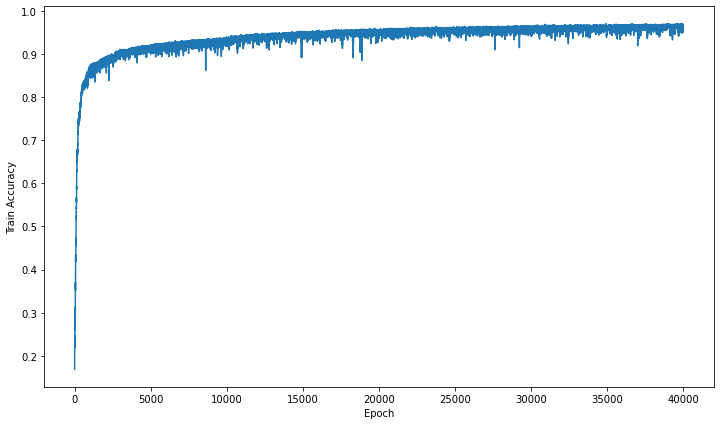

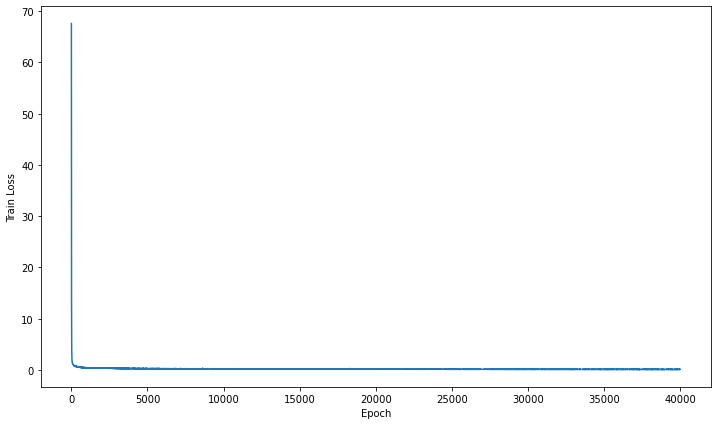

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       154
           1       0.98      0.97      0.98       703
           2       0.95      0.93      0.94       702
           3       0.93      0.97      0.95       703
           4       0.99      1.00      1.00       702

    accuracy                           0.96      2964
   macro avg       0.95      0.95      0.95      2964
weighted avg       0.96      0.96      0.96      2964



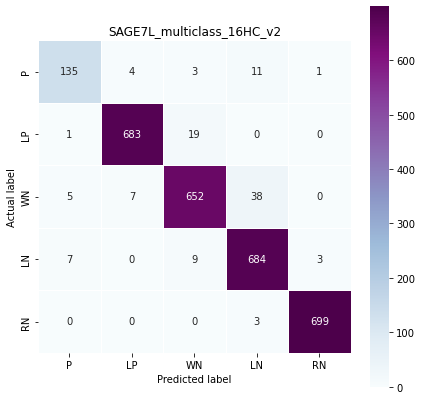

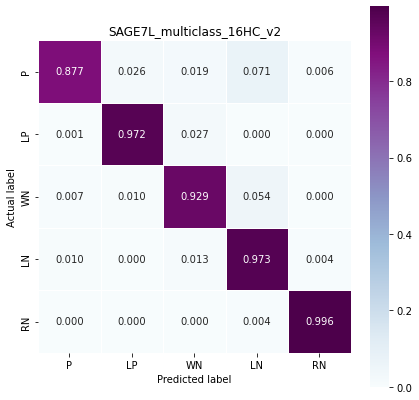

In [29]:
gnn_sage = GNN7L_Sage(data_with_nedbit).to(device)
pred = train(gnn_sage, data_with_nedbit.to(device), 40000, cm_title='SAGE7L_multiclass_16HC_v2', classes=['P', 'LP', 'WN', 'LN', 'RN'], weight_decay=0.0005)